# kmeansとxmeansのスクラッチ実装で学ぶPythonのクラス

## kmeans

In [8]:
import numpy as np

class Kmeans:
        
    def __init__(self):
        
        self.X = None
        self.N = None
        self.M = None
        self.K = None
        self.max_iter = 1000
        self.labels  = None 
        self.centers = None
        
    
    def kmeans (self, X, K = 2):

        self.X = X
        self.N, self.M = self.X.shape
        self.K = K
        self.__initialize_centers()
        self.__update_labels(); 
        old_labels = self.labels
        
        iter = 0
        while True:
            
            self.__update_centers()
            self.__update_labels()
            
            if np.all(old_labels == self.labels):
                print("iteration {n}".format(n = iter))
                break
            old_labels = self.labels
                                   
            iter += 1
            if iter  > self.max_iter :
                print("iteration reached {max}".format(max = self.max_iter))
                break
        
        return None
        
        
    def __initialize_centers(self):
        
        random_center_indexs = np.random.choice(a = self.N, size = self.K, replace = False)
        self.centers = self.X[random_center_indexs,:]
        
        return None
    
    
    def __update_centers(self):
            
        new_centers = []
        for k_label in np.arange(self.K):
            k_center = np.mean(self.X[self.labels == k_label, :], axis = 0)
            new_centers.append(k_center)
        self.centers = np.array(new_centers)
                    
        return None
                     
    
    def __update_labels(self):
        
        dist2 = np.sum((self.X[np.newaxis, :, :] - self.centers[:, np.newaxis, :]) ** 2, axis = 2)
        self.labels = np.argmin(dist2, axis = 0)
        
        return None
    

        

In [9]:
X = np.random.normal(size = 300  * 2).reshape(300, 2)
km = Kmeans()
km.kmeans(X, 3)

iteration 12


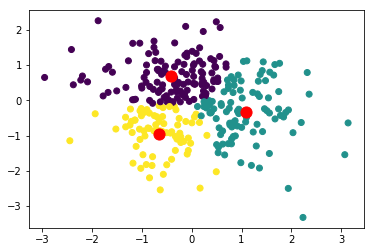

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
ax.scatter(km.X[:,0], km.X[:,1], c = km.labels)
ax.scatter(km.centers[:, 0], km.centers[:, 1], c = "red", s = 124)

## xmeans

In [11]:
from scipy.stats import multivariate_normal as mulnorm
from scipy import stats
import numpy as np


class Xmeans:
    
    def __init__(self):
        self.X = None
        self.N = None
        self.M = None
        self.labels   = None 
        self.clusters = []    # set of data index by cluster
        self.centers  = None
        self.km = Kmeans()
        
    def xmeans(self, X):
        self.X = X
        self.N, self.M = X.shape
        self.__recursive_kmeans()
        self.centers = np.array([np.mean(X[cls, :], axis = 0) for cls in self.clusters])
        labs = np.zeros(self.N)
        for i, cls in enumerate(self.clusters):
            labs[cls] = i
        self.labels = labs
        self.X = None
        
        return None
        
    
    def __recursive_kmeans(self, cluster = None):
        if cluster is None:
            cluster = np.arange(self.N)
        self.km.kmeans(X[cluster, :], 2)
        labs = self.km.labels
        if not self.__is_computable(labs):
            self.clusters.append(cluster)
            return None
        
        splt_cls = [cluster[np.where(labs == v)] for v in np.unique(labs)]
        xbic  = self.__xbic(self.X[cluster, :])
        xbicp = self.__xbicp(self.X[splt_cls[0], :], self.X[splt_cls[1], :]) 
        
        if xbicp < xbic:
            for cls in splt_cls:
                self.__recursive_kmeans(cls)
        else:
            self.clusters.append(cluster)

        return None
        
        
    def __is_computable(self, labs):
        is_zero = labs == 0
        return np.sum(is_zero) >= 3 and np.sum(np.logical_not(is_zero)) >= 3
            
    
    def __xbic(self, X):
        N, M = X.shape
        cv = np.cov(X.T)
        df = M * (M + 3) * .5
        center = np.mean(X, axis = 0)
        bic = - 2 * np.sum(mulnorm.logpdf(X, center, cv)) + df * np.log(N)
        
        return bic
    
    
    def __xbicp(self, X1, X2):
        N1, M  = X1.shape
        N2, _  = X2.shape
        df = M * (M  + 3)
        
        centers = np.array([np.mean(X, axis = 0) for X in [X1, X2]])
        covs = [np.cov(X.T) for X in [X1, X2]]
        sum_dets = np.sum([np.linalg.det(cov) for cov in covs])
        
        beta = np.sqrt(np.sum((centers[0] - centers[1]) **2) / sum_dets)
        log_alpha = - np.log(2) - stats.norm.logcdf(beta)
        loglikelihood = np.sum([np.sum(mulnorm.logpdf(X, cet, cov)) for X, cet, cov in zip([X1, X2], centers, covs)])
        
        bicp = - 2 * ((N1 + N2) * log_alpha + loglikelihood) + df * np.log(N1 + N2)
        
        return bicp
        
 
    


In [12]:
X1 = np.random.normal(size = 100  * 2).reshape(100, 2) * .8
X2 = X1 + np.array([5,  0])
X3 = X1 + np.array([0,  5])
X4 = X1 + np.array([-5,  0])
X5 = X1 + np.array([0, -5])
X  = np.r_[X1, X2, X3, X4, X5]
xkm = Xmeans()
xkm.xmeans(X)

iteration 0
iteration 4
iteration 2
iteration 7
iteration 2
iteration 10
iteration 7
iteration 12
iteration 6


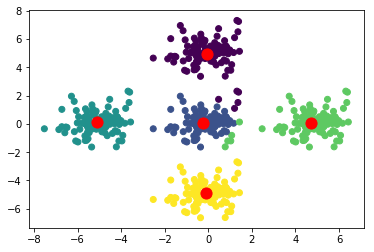

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = xkm.labels)
ax.scatter(xkm.centers[:, 0], xkm.centers[:, 1], c = "red", s = 124)